# CS171 Final Project
### By Anton Clayton
#### Dataset Link: https://www.kaggle.com/datasets/alessiocorrado99/animals10

## 1. Data Preprocessing

## OPTION 1: If you put the dataset ZIP file into google drive
Run this if the file animals-dataset.zip is already in your Drive folder.


In [ ]:
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

In [1]:
import shutil
import os

# Copy and Unzip
# Update this path if zip is named differently or in a different folder
drive_zip_path = '/content/drive/MyDrive/CS171_animals_dataset/animals-dataset.zip'
local_extract_path = '/content/animal_data'

print("Copying and unzipping from Drive...")
shutil.copy(drive_zip_path, '/content/temp.zip')
shutil.unpack_archive('/content/temp.zip', local_extract_path)

# Setup variables for loop
base_path = f'{local_extract_path}/raw-img'
image_filepaths = []
image_labels = []

print(f"'base_path' is set to: {base_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Copying and unzipping from Drive...
Done! 'base_path' is set to: /content/animal_data/raw-img


## OPTION 2: If you upload the dataset ZIP file locally/manually
Run this if you just dragged and dropped animals-dataset.zip into the Colab "Files" sidebar.

In [ ]:
import shutil
import os

# 1. Unzip the uploaded file
# Make sure the uploaded file is named exactly this, or change the string below
uploaded_zip_name = 'animals-dataset.zip'
local_zip_path = f'/content/{uploaded_zip_name}'
local_extract_path = '/content/animal_data'

if os.path.exists(local_zip_path):
    print(f"Unzipping {uploaded_zip_name}...")
    shutil.unpack_archive(local_zip_path, local_extract_path)

    # Setup variables for loop
    base_path = f'{local_extract_path}/raw-img'
    image_filepaths = []
    image_labels = []

    print(f"Done! 'base_path' is set to: {base_path}")
else:
    print(f"Error: Could not find '{uploaded_zip_name}'. Did you upload it to the Files sidebar?")

Unzipping animals-dataset.zip...


ReadError: /content/animals-dataset.zip is not a zip file

In [2]:
from collections import defaultdict
# Initialize a defaultdict to count images per class, limited to 1000
class_counts = defaultdict(int)
limit_per_class = 1000

print(f"Starting image collection with a limit of {limit_per_class} images per class...")

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        # Only process if the class count is below the limit or not yet started
        if class_counts[class_name] < limit_per_class:
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if class_counts[class_name] < limit_per_class:
                        img_path = os.path.join(class_path, img_name)
                        image_filepaths.append(img_path)
                        image_labels.append(class_name)
                        class_counts[class_name] += 1
                    else:
                        # Already collected 1000 images for this class, move to next file
                        break # Exit inner loop for this class

print(f"Finished collecting image paths. Total image paths collected: {len(image_filepaths)}")
print("Number of images collected per class (limited to 1000):")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

Starting image collection with a limit of 1000 images per class...
Finished collecting image paths. Total image paths collected: 10000
Number of images collected per class (limited to 1000):
- scoiattolo: 1000
- elefante: 1000
- gatto: 1000
- ragno: 1000
- cavallo: 1000
- cane: 1000
- pecora: 1000
- gallina: 1000
- mucca: 1000
- farfalla: 1000


In [3]:
import collections
from PIL import Image

# Print the total number of images
print(f"Total number of images loaded: {len(image_filepaths)}")

# Count and display the number of images for each class to confirm 1000
class_counts = collections.Counter(image_labels)
print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

# Select and display the dimensions of a few sample images
print("\nDimensions of a few sample images:")
# Display dimensions for the first 5 images just to see
for i in range(min(5, len(image_filepaths))):
    img_path = image_filepaths[i]
    try:
        with Image.open(img_path) as img_obj:
            print(f"- Image {i+1} (Class: {image_labels[i]}): {img_obj.size[0]}x{img_obj.size[1]} pixels")
    except Exception as e:
        print(f"- Could not open image {img_path}: {e}")

# Display dimensions for a few images from the middle of the dataset just to see
if len(image_filepaths) > 10:
    for i in range(len(image_filepaths) // 2, min(len(image_filepaths) // 2 + 3, len(image_filepaths))):
        img_path = image_filepaths[i]
        try:
            with Image.open(img_path) as img_obj:
                print(f"- Image {i+1} (Class: {image_labels[i]}): {img_obj.size[0]}x{img_obj.size[1]} pixels")
        except Exception as e:
            print(f"- Could not open image {img_path}: {e}")

Total number of images loaded: 10000

Number of images per class:
- scoiattolo: 1000
- elefante: 1000
- gatto: 1000
- ragno: 1000
- cavallo: 1000
- cane: 1000
- pecora: 1000
- gallina: 1000
- mucca: 1000
- farfalla: 1000

Dimensions of a few sample images:
- Image 1 (Class: scoiattolo): 300x200 pixels
- Image 2 (Class: scoiattolo): 300x200 pixels
- Image 3 (Class: scoiattolo): 218x300 pixels
- Image 4 (Class: scoiattolo): 300x232 pixels
- Image 5 (Class: scoiattolo): 300x200 pixels
- Image 5001 (Class: cane): 266x300 pixels
- Image 5002 (Class: cane): 300x200 pixels
- Image 5003 (Class: cane): 300x225 pixels


In [4]:
# Map labels from Italian to English
translation_map = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

# Translate labels in-place
for i in range(len(image_labels)):
    image_labels[i] = translation_map.get(image_labels[i], image_labels[i])

print("Labels translated successfully.")

# Verify a few sample translated labels
print("\nSample translated labels (first 5):")
for i in range(min(5, len(image_labels))):
    print(f"- {image_labels[i]}")

# Pprint counts of each translated label (sanity check)
from collections import Counter
translated_class_counts = Counter(image_labels)
print("\nNumber of images per translated class:")
for class_name, count in translated_class_counts.items():
    print(f"- {class_name}: {count}")

Labels translated successfully.

Sample translated labels (first 5):
- squirrel
- squirrel
- squirrel
- squirrel
- squirrel

Number of images per translated class:
- squirrel: 1000
- elephant: 1000
- cat: 1000
- spider: 1000
- horse: 1000
- dog: 1000
- sheep: 1000
- chicken: 1000
- cow: 1000
- butterfly: 1000


In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    image_filepaths,
    image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state=42
)

print(f"Total processed images: {len(image_filepaths)}")
print(f"Training set size: {len(X_train)} images")
print(f"Testing set size: {len(X_test)} images")

# Verify the class distribution in training and testing sets
from collections import Counter

print("\nTraining set class distribution:")
for label, count in Counter(y_train).items():
    print(f"- {label}: {count}")

print("\nTesting set class distribution:")
for label, count in Counter(y_test).items():
    print(f"- {label}: {count}")

Total processed images: 10000
Training set size: 8000 images
Testing set size: 2000 images

Training set class distribution:
- dog: 800
- cat: 800
- elephant: 800
- squirrel: 800
- horse: 800
- spider: 800
- butterfly: 800
- sheep: 800
- cow: 800
- chicken: 800

Testing set class distribution:
- dog: 200
- elephant: 200
- cow: 200
- chicken: 200
- sheep: 200
- spider: 200
- cat: 200
- horse: 200
- butterfly: 200
- squirrel: 200


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

# Define Transforms (both produce 3x224x224 tensor)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),        # Resize slightly larger for next step
    transforms.RandomResizedCrop(224),    # Crop a random part (Augmentation)
    transforms.RandomHorizontalFlip(),    # Flip horizontally (Augmentation)
    transforms.ToTensor(),                # Converts to [0,1] (replaces / 255.0)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet stats
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # specific target size (for consistency)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define Label Mapping

We need to create a mapping from string labels to integer labels, as deep learning models typically work with numerical labels. This will also ensure consistent indexing for our 10 classes.

In [7]:
# Lazy-Loading Dataset (to avoid Colab RAM/memory issues)
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, label_to_int, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.label_to_int = label_to_int
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image ONLY when training loop asks for it
        img_path = self.image_paths[idx]
        # .convert('RGB') fixes the grayscale/RGBA issues automatically
        image = Image.open(img_path).convert('RGB')

        label_str = self.labels[idx]
        label_int = self.label_to_int[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label_int

In [8]:
# Create Datasets and Loaders
unique_labels = sorted(list(set(image_labels)))
label_to_int = {label: i for i, label in enumerate(unique_labels)}

train_dataset = CustomImageDataset(X_train, y_train, label_to_int, transform=train_transforms)
test_dataset = CustomImageDataset(X_test, y_test, label_to_int, transform=test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train Loader ready with {len(train_dataset)} images.")
print(f"Test Loader ready with {len(test_dataset)} images.")

Train Loader ready with 8000 images.
Test Loader ready with 2000 images.


## 2. Model Construction

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class AnimalClassificationCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalClassificationCNN, self).__init__()

        # --- CONVOLUTIONAL LAYERS ---
        # Block 1: Input (3, 224, 224) -> Output (32, 112, 112)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces Image Size by half

        # Block 2: Input (32, 112, 112) -> Output (64, 56, 56)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Block 3: Input (64, 56, 56) -> Output (128, 28, 28)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # --- FULLY CONNECTED LAYERS ---
        # The input to the linear layer is: Channels * Height * Width
        # Based on the blocks above: 128 * 28 * 28 = 100,352 features
        self.flatten_size = 128 * 28 * 28

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.5) # Helps prevent overfitting
        self.fc2 = nn.Linear(512, num_classes) # Output layer (10 classes)

    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.conv1(x)))
        # Block 2
        x = self.pool(F.relu(self.conv2(x)))
        # Block 3
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten: Turn the 3D image cubes into a 1D vector
        x = x.view(-1, self.flatten_size)

        # Classification Head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # No softmax here! CrossEntropyLoss handles it.
        return x

In [11]:
import torch.optim as optim

# 1. Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# 2. Initialize the model and move it to the GPU
model = AnimalClassificationCNN(num_classes=10)
model = model.to(device)

# 3. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized successfully.")

Training on device: cuda
Model initialized successfully.


In [12]:
from tqdm.auto import tqdm

# Set number of epochs
num_epochs = 30

# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # --- TRAINING ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Wrap the train_loader with tqdm to show progress bar
    # desc sets the text description for the bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update the progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # --- VALIDATION ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Complete! "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

print("Training Complete!")

Starting Training Loop...


Epoch 1/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [1/30] Complete! Train Acc: 14.21% | Val Acc: 17.70%


Epoch 2/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [2/30] Complete! Train Acc: 18.71% | Val Acc: 23.35%


Epoch 3/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [3/30] Complete! Train Acc: 23.65% | Val Acc: 25.50%


Epoch 4/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [4/30] Complete! Train Acc: 29.95% | Val Acc: 36.25%


Epoch 5/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [5/30] Complete! Train Acc: 33.09% | Val Acc: 42.30%


Epoch 6/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [6/30] Complete! Train Acc: 36.51% | Val Acc: 45.05%


Epoch 7/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [7/30] Complete! Train Acc: 38.81% | Val Acc: 45.55%


Epoch 8/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [8/30] Complete! Train Acc: 40.24% | Val Acc: 45.40%


Epoch 9/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [9/30] Complete! Train Acc: 41.71% | Val Acc: 50.95%


Epoch 10/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [10/30] Complete! Train Acc: 43.52% | Val Acc: 51.20%


Epoch 11/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [11/30] Complete! Train Acc: 44.51% | Val Acc: 51.80%


Epoch 12/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [12/30] Complete! Train Acc: 45.25% | Val Acc: 52.05%


Epoch 13/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [13/30] Complete! Train Acc: 46.34% | Val Acc: 53.50%


Epoch 14/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [14/30] Complete! Train Acc: 46.27% | Val Acc: 57.00%


Epoch 15/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [15/30] Complete! Train Acc: 49.14% | Val Acc: 53.65%


Epoch 16/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [16/30] Complete! Train Acc: 48.09% | Val Acc: 57.95%


Epoch 17/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [17/30] Complete! Train Acc: 49.26% | Val Acc: 56.70%


Epoch 18/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [18/30] Complete! Train Acc: 49.77% | Val Acc: 58.20%


Epoch 19/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [19/30] Complete! Train Acc: 50.44% | Val Acc: 57.75%


Epoch 20/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [20/30] Complete! Train Acc: 51.90% | Val Acc: 56.90%


Epoch 21/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [21/30] Complete! Train Acc: 51.20% | Val Acc: 59.85%


Epoch 22/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [22/30] Complete! Train Acc: 52.11% | Val Acc: 57.75%


Epoch 23/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [23/30] Complete! Train Acc: 52.34% | Val Acc: 57.00%


Epoch 24/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [24/30] Complete! Train Acc: 53.06% | Val Acc: 60.00%


Epoch 25/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [25/30] Complete! Train Acc: 53.14% | Val Acc: 61.05%


Epoch 26/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [26/30] Complete! Train Acc: 54.27% | Val Acc: 61.80%


Epoch 27/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [27/30] Complete! Train Acc: 54.09% | Val Acc: 59.70%


Epoch 28/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [28/30] Complete! Train Acc: 54.51% | Val Acc: 61.55%


Epoch 29/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [29/30] Complete! Train Acc: 55.09% | Val Acc: 62.95%


Epoch 30/30 [Train]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch [30/30] Complete! Train Acc: 55.62% | Val Acc: 61.35%
Training Complete!


## 3. Analysis and Visualization

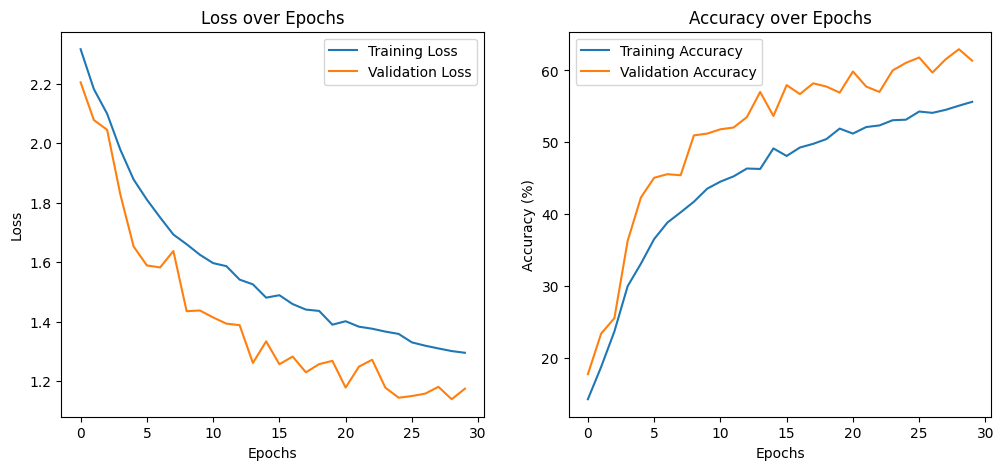

In [13]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# more coming